# Combined_Evaluation

This notebook finds polymer:acronym pairs from documents in a database. These pairs are then used to augment a list of polymer candidates found and then evaluate those candidates against a groundtruth list of polymers.

In [1]:
# -*- coding: utf-8 -*-
import os
import re
import csv
import sys
import glob
import errno
import random
import sqlite3
import subprocess
import pandas as pd
import pymysql.cursors
import gensim, logging
from __future__ import division
import matplotlib.pyplot as plt
from gensim.models import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from abbreviations import get_abbreviations

# Avoid ascii error
reload(sys)
sys.setdefaultencoding('utf8')

Create connection to database 

In [2]:
# Connect to db
def connect_to_db():
    database = "db/sentences.db"
    conn = create_connection(database)
    return conn

In [3]:
# Connect to DB
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

Sentences are retrieved from database documents and placed in a list

In [4]:
def get_sentences_for_dois(doi,conn):
    sentences = []
    cur = conn.cursor()
    query = "select sentence from sentences where docid='%s'" % (doi)
    cur.execute(query)
    rows = cur.fetchall()
    for row in rows:
        sentences.append(row[0].rstrip("."))

    return sentences

In [5]:
def get_polymers(doi_input_file, entire_document):

    f = open(doi_input_file,'rb')
    lines = f.readlines()
    print('Processing %d documents as listed in %s' % (len(lines), doi_input_file))
    sentences2 = []
    connection = connect_to_db()
    
    # Process line in prediction file
    for line in lines:

        # Read the doi
        doi = line.split("\t")[0].strip("\n")
         
        if entire_document == 1:
            sentences = get_sentences_for_dois(doi,connection)
            
        for sentence in sentences: 
            sentences2.append(sentence)

    return sentences2

In [6]:
#get sentences from documents
sentences_list = get_polymers('data/classifier_dois.txt', 1)

Acronym:Longname pairs are found from the database sentences using get_abbreviations and placed into a dictionary

In [7]:
#get dictionary of abbreviations:polymers
abbrs = get_abbreviations(sentences_list)

A list of found polymer candidates (polymer_candidates.txt) is augmented by any matching acronyms found in the previous step and the augmented list is rewritten. For example: 
- If polystyrene is in the list of polymer candidates, the found acronym PS and polystyrene are _both_ added to the new list of polymer candidates

In [8]:
#open file of polymer candidates/create new file

f = open('output/amber_second_candidates.txt','w+')

In [9]:
def cleanup_poly(pl):
    new_pl = pl.strip().strip(',').strip('.')
    if len(new_pl)>=2 and new_pl[0] == '(' and new_pl[len(new_pl)-1]==')':
        new_pl=new_pl.rstrip(')').lstrip('(')
    return new_pl

In [10]:
def read_items(ifile):
    items = []
    f = open(ifile)
    lines = f.readlines()
    for line in lines:
        poly = cleanup_poly(line.strip("\n"))
        upoly = u'%s' % (poly)
        items.append(upoly)
    return items

In [11]:
# separate candidates combined by /, :, or –

def split (jfile):
    
    candidate_polymers = read_items(jfile)
    
    candidate_polymers_2 = []
    for string in candidate_polymers:
        if ":" in string: 
            x = string.split(":")
            for string in x:
                line_string = '%s\n' % (string.strip())
                candidate_polymers_2.append(line_string)
        if "/" in string: 
            y = string.split("/")
            for string in y:
                line_string = '%s\n' % (string.strip())
                candidate_polymers_2.append(line_string)
        if "–" in string: 
            z = string.split("–")
            for string in z:
                line_string = '%s\n' % (string.strip())
                candidate_polymers_2.append(line_string)
        
        
    joined_list = ''.join(candidate_polymers_2)
    
    for line in joined_list: 
        if line not in candidate_polymers: 
            candidate_polymers.append(line)

    return candidate_polymers

In [12]:
#format candidates

candidates_list = split('input/polymer_candidates.txt')


formatted_strings = list()
for string in candidates_list: 
    plain_string = string.rstrip('\n')  
    if "[u'" in plain_string: 
        plain_string = plain_string.replace("[u'","")
        plain_string = plain_string.replace("']","")
    else: 
        pass
    
    unicode_string = plain_string.decode('utf8')
    formatted_strings.append(unicode_string)

In [13]:
#find and record matching pairs

for string in formatted_strings:
    f.write('%s\n' % (string))
    for key in abbrs: 
        if string in abbrs[key]:
            line_acronym = '%s\n' % (key)
            f.write(line_acronym)
        if string in key: 
            mod = ''.join(abbrs[key])
            line_polymer = '%s\n' % (mod)
            f.write(line_polymer)

In [14]:
#close file
f.close()

Evaluate augmented candidates found against groundtruth polymers from documents in the database

In [15]:
def read_items(ifile):
    items = []
    f = open(ifile)
    lines = f.readlines()
    for line in lines:
        poly = cleanup_poly(line.strip("\n"))
        upoly = u'%s' % (poly)
        items.append(upoly)
    return items

In [16]:
def evaluate (candidate_file, groundtruth_file, n):
    
    candidate_polymers = read_items(candidate_file)
    extracted_polymers = read_items(groundtruth_file)
    
    print (len(candidate_polymers))
    print (len(extracted_polymers))
    
    candidate_polymers = candidate_polymers[0:n]
    
    print 'keywords:', len(candidate_polymers)

    groundtruth_polymers = [x.strip().lower() for x in extracted_polymers]
    groundtruth_polymers = list(set(groundtruth_polymers))
    print "Number of polymer names in the dictionary: ", len(groundtruth_polymers)

    candidate_polymers = [x.strip().lower() for x in candidate_polymers]
    candidate_polymers = list(set(candidate_polymers))
    print "Number of candidate polymers in this file: ", (len(candidate_polymers))
    
    # Perform evaluation (compute truth positives, false positives and false negatives)
    TP = 0
    FP = 0
    for candidate in candidate_polymers:
        if candidate in groundtruth_polymers:
            TP = TP + 1
        else:
            FP = FP + 1

    precision = (TP/(TP+FP)*100)

    FN = 0
    for poly in groundtruth_polymers:
        if poly not in candidate_polymers:
            FN = FN + 1

    recall = (TP/(TP+FN)*100)

    print "True pos: ", TP
    print "False pos: ", FP
    print "Precision: ", precision
    print "Recall: ", recall

The number of keywords used in the evaluation can be controlled by changing n- which has a maximum of 322 when using input/scraped_polymer_names.txt

In [17]:
#evaluate where n = number of keywords to evaluate with from candidate file
evaluate('input/scraped_polymer_names.txt', 'evaluation/ground_truth_list_format.txt', n = 322)

### Graphing

Two graphs are produced, one which demonstrates how recall and precision change over number of keywords (Fig. 1) and the other two demonstrating the distribution of recall (Fig. 2) and precision (Fig. 3)

In [18]:
# function returns precision of the two lists
def precision (list1, list2, N):
    
    TP = 0
    FP = 0
    limited_list = list1[:N]
    for candidate in limited_list:
        if candidate in list2:
            TP = TP + 1
        else:
            FP = FP + 1

    precision = (TP/(TP+FP)*100)
        
    precision = int(precision)
        
    return precision

In [19]:
# function returns recall of the two lists
def recall (list1, list2, N):
    
    TP = 0
    FP = 0
    limited_list = list1[:N]
    for candidate in limited_list:
        if candidate in list2:
            TP = TP + 1
        else:
            FP = FP + 1

    FN = 0
    for poly in list2:
        if poly not in list1:
            FN = FN + 1

    recall = (TP/(TP+FN)*100)
    
    recall = int(recall)
        
    return recall

In [20]:
# function counts number of keywords in the input file
def values (filename): 
    
    candidate_polymers = read_items(filename)
    
    N = 0
    values = list()
    
    for string in candidate_polymers:
        N = N+1
        values.append(N)
        
    return values

In [21]:
def plot_evaluation(candidate_file, groundtruth_file):
    
    candidate_polymers = read_items(candidate_file)
    extracted_polymers = read_items(groundtruth_file)

    groundtruth_polymers = [x.strip().lower() for x in extracted_polymers]
    groundtruth_polymers = list(set(groundtruth_polymers))

    candidate_polymers = [x.strip().lower() for x in candidate_polymers]
    candidate_polymers = list(set(candidate_polymers))    
        
    plt.ylabel('percentage')
    plt.xlabel('# of keywords')
    
    values_ = values(candidate_file)
    
    precisions_ = list()
    
    recalls_ = list()
    
    for item in values_:
        
        N = item
        
        #precision curve
        precision_ = precision(candidate_polymers, groundtruth_polymers, N)
        precisions_.append(precision_)


        #recall curve
        recall_ = recall(candidate_polymers, groundtruth_polymers, N)
        recalls_.append(recall_)
        
    
    plt.plot(values_, precisions_, 'or-')
    plt.plot(values_, recalls_, 'ob-')
    
    plt.show()
    

### Fig. 1

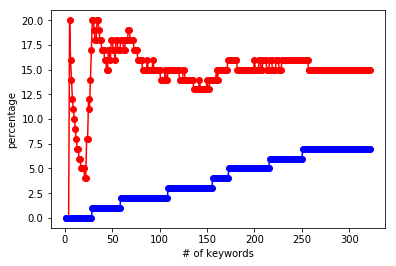

In [22]:
plot_evaluation('input/scraped_polymer_names.txt', 'evaluation/ground_truth_list_format.txt')

In [31]:
#histogram 

def histogram_evaluation_recall(candidate_file, groundtruth_file):
    
    candidate_polymers = read_items(candidate_file)
    extracted_polymers = read_items(groundtruth_file)

    groundtruth_polymers = [x.strip().lower() for x in extracted_polymers]
    groundtruth_polymers = list(set(groundtruth_polymers))

    candidate_polymers = [x.strip().lower() for x in candidate_polymers]
    candidate_polymers = list(set(candidate_polymers))    
        
    plt.ylabel('probability')
    plt.xlabel('Recall')
    
    values_ = values(candidate_file)
    
    recalls_ = list()
    
    for item in values_:
        
        N = item

        #recall curve
        recall_ = recall(candidate_polymers, groundtruth_polymers, N)
        recalls_.append(recall_)
        
    plt.hist(recalls_, facecolor='red')
    
    plt.show()


### Fig. 2

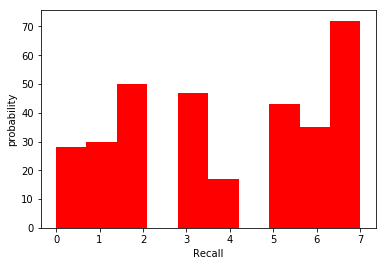

In [32]:
histogram_evaluation_recall('input/scraped_polymer_names.txt', 'evaluation/ground_truth_list_format.txt')

In [35]:
#histogram 

def histogram_evaluation_precision(candidate_file, groundtruth_file):
    
    candidate_polymers = read_items(candidate_file)
    extracted_polymers = read_items(groundtruth_file)

    groundtruth_polymers = [x.strip().lower() for x in extracted_polymers]
    groundtruth_polymers = list(set(groundtruth_polymers))

    candidate_polymers = [x.strip().lower() for x in candidate_polymers]
    candidate_polymers = list(set(candidate_polymers))    
        
    plt.ylabel('probability')
    plt.xlabel('Precision')
    
    values_ = values(candidate_file)
    
    precisions_ = list()
    
    for item in values_:
        
        N = item
        
        #precision curve
        precision_ = precision(candidate_polymers, groundtruth_polymers, N)
        precisions_.append(precision_)
        
    plt.hist(precisions_, facecolor='blue')
    
    plt.show()


### Fig. 3

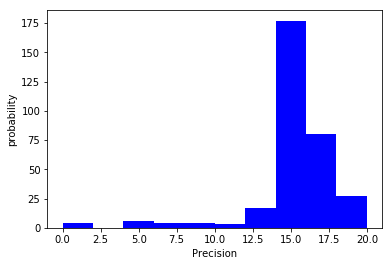

In [36]:
histogram_evaluation_precision('input/scraped_polymer_names.txt', 'evaluation/ground_truth_list_format.txt')